# Face Recognition -Model8

使用MTCNN進行人臉偵測

使用自建CNN模型進行人臉辨識

使用kaggle5位日本明星資料集

進行靜態圖像辨識

Transfer learning-VGG


In [1]:
from __future__ import division

# 將警告訊息關掉
import warnings
warnings.filterwarnings('ignore')

#Utilities相關函式庫
import os
import sys

# Python2.X和3.X相容
import six

# 圖像處理函示庫
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

# 數值處理函式庫
import pandas as pd
import numpy as np

# 機器學習函式庫
from sklearn.model_selection import train_test_split

# 深度學習函式庫
import keras 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Convolution2D, Dropout, Flatten, merge, Reshape, Activation, Lambda, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, add, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import RMSprop, Adam, SGD
from keras.utils import np_utils
from keras import regularizers
from keras import initializers
from keras.regularizers import l2
from keras import initializers
from keras.engine import Layer, InputSpec, get_source_inputs
from keras_vggface.vggface import VGGFace
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input


# Backend
from keras import backend as K

# 人臉偵測函式庫
from mtcnn import MTCNN
detector = MTCNN()

# 相關參數設定
picture_size = 224
batch_size = 8  # 一次用多少筆資料更新模型
num_classes = 5  # 資料集有幾個類別
epochs = 200      # 訓練迭代次數
save_dir = os.path.join(os.getcwd(), 'saved_models') # 儲存模型的路徑
model_name = 'Model8_Transfer_VGG_V2, trained_model.h5' # 模型名稱


Using TensorFlow backend.


In [2]:
# 直接讀取處理好的檔案
total_img_resized = np.load('total_crop_resized.npy')
labelnames = np.load('labelnames.npy')
total_img_resized.shape

(448, 224, 224, 3)

In [3]:
# 切分訓練/測試資料
#train_x = total_img
#train_y = labelnames

train_x,test_x, train_y, test_y = train_test_split(total_img_resized,
                                                  labelnames,
                                                test_size = 0.1,stratify= labelnames)#random_state = 123,
print('train:',train_x.shape,'test:',test_x.shape)

# 正規化資料
# 標準化0~255的值到0~1
# x_train_normalize = train_x.astype('float32') / 255.0
# x_test_normalize = test_x.astype('float32') / 255.0
x_train_normalize = preprocess_input(train_x)
x_test_normalize = preprocess_input(test_x)


train: (403, 224, 224, 3) test: (45, 224, 224, 3)


In [8]:
# Transfer learning-VGG
from keras_vggface.vggface import VGGFace

img_rows, img_cols, img_channel = picture_size, picture_size, 3


#custom parameters
nb_class = 5

base_model = VGGFace(model='resnet50',include_top=False, input_shape=(img_rows, img_cols, img_channel))


# 凍結基底模型的權重，不更新
for layer in base_model.layers:
    layer.trainable = False

last_layer = base_model.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dense(4096)(x)
out = Dense(nb_class, activation='softmax', name='classifier')(x)
model = Model(base_model.input, out)
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_5[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

In [9]:
# 訓練模型
optimizer = Adam(lr=3e-6,decay=0.0001,beta_1=0.99,beta_2=0.999) #100e-6
# sgd = keras.optimizers.SGD(lr=3e-6, momentum=0.9, decay=1e-5, nesterov=True)
model.compile(loss = 'categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])

In [10]:
# Data Augmentation
datagen  = ImageDataGenerator(
            rotation_range = 20,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            horizontal_flip = True, 
            vertical_flip = False,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode='nearest')

In [11]:
# Use ModelCheckpoint to save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, verbose = 1)

earlystop = EarlyStopping(monitor = 'val_loss', patience = 20, verbose = 1) # patience=10為連續10次模型loss沒再下降就停止

# Fit model
aug_ratio = 2
steps_per_epoch = int(aug_ratio * train_x.shape[0] / batch_size)
validation_steps = int(aug_ratio * test_x.shape[0] / batch_size)

model_history = model.fit_generator(datagen.flow(x_train_normalize, train_y, batch_size = batch_size),
                                   epochs = epochs,
                                   validation_data = (x_test_normalize, test_y),
                                   callbacks = [checkpoint, earlystop],
                                   steps_per_epoch=steps_per_epoch,
                                   validation_steps=validation_steps
                                   )

Epoch 1/200
100/100 [==============================] - 34s 338ms/step - loss: 1.4018 - acc: 0.4933 - val_loss: 0.6146 - val_acc: 0.7556

Epoch 00001: val_loss improved from inf to 0.61455, saving model to d:\Side Project\Face Recognition\saved_models\Model8_Transfer_VGG_V2, trained_model.h5
Epoch 2/200
100/100 [==============================] - 24s 240ms/step - loss: 0.5456 - acc: 0.8129 - val_loss: 0.2504 - val_acc: 0.9333

Epoch 00002: val_loss improved from 0.61455 to 0.25043, saving model to d:\Side Project\Face Recognition\saved_models\Model8_Transfer_VGG_V2, trained_model.h5
Epoch 3/200
100/100 [==============================] - 24s 236ms/step - loss: 0.3802 - acc: 0.8742 - val_loss: 0.1521 - val_acc: 0.9556

Epoch 00003: val_loss improved from 0.25043 to 0.15208, saving model to d:\Side Project\Face Recognition\saved_models\Model8_Transfer_VGG_V2, trained_model.h5
Epoch 4/200
100/100 [==============================] - 24s 238ms/step - loss: 0.3002 - acc: 0.8879 - val_loss: 0.153

100/100 [==============================] - 24s 237ms/step - loss: 0.1202 - acc: 0.9575 - val_loss: 0.0488 - val_acc: 0.9778

Epoch 00035: val_loss did not improve from 0.03573
Epoch 36/200
100/100 [==============================] - 24s 236ms/step - loss: 0.1121 - acc: 0.9604 - val_loss: 0.0332 - val_acc: 0.9778

Epoch 00036: val_loss improved from 0.03573 to 0.03321, saving model to d:\Side Project\Face Recognition\saved_models\Model8_Transfer_VGG_V2, trained_model.h5
Epoch 37/200
100/100 [==============================] - 24s 237ms/step - loss: 0.0968 - acc: 0.9650 - val_loss: 0.0330 - val_acc: 1.0000

Epoch 00037: val_loss improved from 0.03321 to 0.03304, saving model to d:\Side Project\Face Recognition\saved_models\Model8_Transfer_VGG_V2, trained_model.h5
Epoch 38/200
100/100 [==============================] - 24s 235ms/step - loss: 0.1012 - acc: 0.9687 - val_loss: 0.0556 - val_acc: 0.9778

Epoch 00038: val_loss did not improve from 0.03304
Epoch 39/200
100/100 [===================


Epoch 00075: val_loss did not improve from 0.02585
Epoch 76/200
100/100 [==============================] - 24s 237ms/step - loss: 0.0691 - acc: 0.9787 - val_loss: 0.0263 - val_acc: 1.0000

Epoch 00076: val_loss did not improve from 0.02585
Epoch 77/200
100/100 [==============================] - 24s 237ms/step - loss: 0.0690 - acc: 0.9721 - val_loss: 0.0344 - val_acc: 1.0000

Epoch 00077: val_loss did not improve from 0.02585
Epoch 78/200
100/100 [==============================] - 24s 236ms/step - loss: 0.0823 - acc: 0.9729 - val_loss: 0.0337 - val_acc: 1.0000

Epoch 00078: val_loss did not improve from 0.02585
Epoch 79/200
100/100 [==============================] - 24s 237ms/step - loss: 0.0925 - acc: 0.9642 - val_loss: 0.0375 - val_acc: 1.0000

Epoch 00079: val_loss did not improve from 0.02585
Epoch 80/200
100/100 [==============================] - 24s 237ms/step - loss: 0.0664 - acc: 0.9804 - val_loss: 0.0396 - val_acc: 0.9778

Epoch 00080: val_loss did not improve from 0.02585
Epo

In [12]:
# loading save model
print('Loading trained model')
model_path = os.path.join(save_dir, model_name)
model = load_model(model_path)

# Score trained model
scores = model.evaluate(x_test_normalize, test_y, verbose = 1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Loading trained model
45/45 [==============================] - 3s 76ms/step
Test loss: 0.025848444551229477
Test accuracy: 1.0


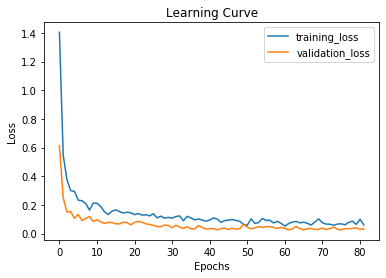

In [13]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()